<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/415_reglin_4.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(group-comp-notebook)=
# Confronto tra le medie di due gruppi

In alcune procedure di inferenza statistica, ci interessa confrontare due gruppi per capire se le loro medie sono diverse o se una è maggiore dell'altra. Tuttavia, questo confronto si riferisce ai parametri delle popolazioni da cui i gruppi sono stati campionati, non alle medie osservate. Quindi, per trovare una risposta, è necessario utilizzare un modello statistico perché le vere differenze sono spesso nascoste dal rumore di misurazione.

Solitamente, il confronto statistico tra due gruppi si basa sull'uso di un test statistico che esprime un'ipotesi nulla che afferma che non vi è alcuna differenza tra i gruppi. Poi, si utilizza una statistica test per verificare se la distribuzione dei dati osservati è plausibile sotto l'ipotesi nulla. L'ipotesi nulla viene rifiutata se la statistica test calcolata sui dati osservati supera un valore prestabilito.

Tuttavia, l'impostazione di un test di ipotesi comporta molte scelte soggettive, e i risultati spesso sono malinterpretati. Inoltre, l'evidenza che fornisce un test di ipotesi è indiretta, incompleta e tipicamente soprastima l'evidenza contro l'ipotesi nulla.

Un approccio più efficace ed informativo è quello basato sulla stima piuttosto che sulla verifica di ipotesi ed è guidato dall'approccio bayesiano piuttosto che da quello frequentista. Invece di testare se due gruppi sono diversi, l'obiettivo è quello di stimare di quanto sono diversi, fornendo una stima dell'incertezza associata a tale differenza, che comprende l'incertezza dovuta alla mancanza di conoscenza sui parametri del modello (incertezza epistemica) e l'incertezza dovuta alla stocasticità intrinseca del sistema (incertezza aleatoria).

## Un esempio illustrativo

In questo esempio, l'obiettivo è stimare la differenza tra le medie del quoziente di intelligenza dei bambini di due gruppi distinti in base al livello di scolarità della madre. Il primo gruppo include i bambini la cui madre non ha completato le scuole superiori, mentre il secondo gruppo comprende quelli la cui madre ha ottenuto il diploma superiore. Per questo, useremo i dati `kidiq` e l'analisi della regressione al fine di ottenere una stima affidabile della differenza tra le medie dei due gruppi nella popolazione.

Iniziamo ad importare le librerie necessarie.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sc
import statistics as st
import arviz as az
import bambi as bmb
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%matplotlib inline

# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

Leggiamo i dati:

In [3]:
kidiq = pd.read_stata("data/kidiq.dta")
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


In [4]:
kidiq.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

Ci sono 93 bambini la cui madre non ha completato le superiori e 341 bambini la cui madre ha ottenuto il diploma di scuola superiore.

In [5]:
summary_stats = [st.mean, st.stdev]
kidiq.groupby(["mom_hs"]).aggregate(summary_stats)


kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

I bambini la cui madre ha completato le superiori tendono ad avere un QI maggiore di 11.8 punti rispetto ai bambini la cui madre non ha concluso le superiori.

In [6]:
89.319648 - 77.548387

11.771260999999996

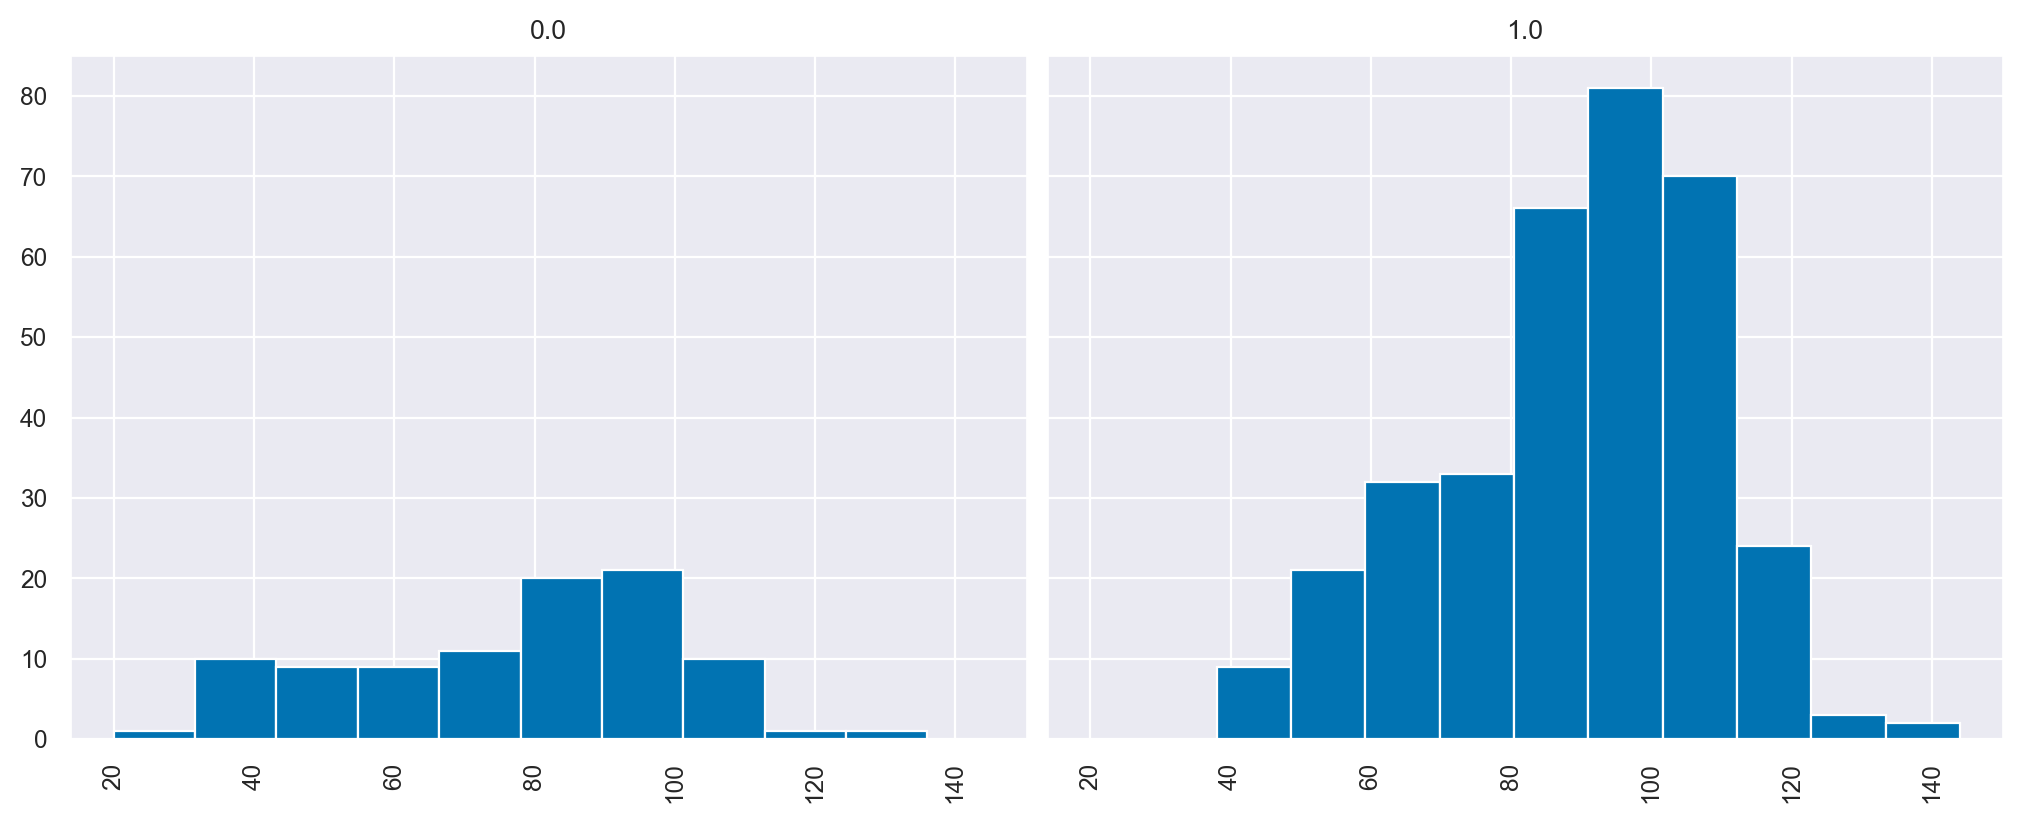

In [7]:
kidiq.hist("kid_score", by="mom_hs", figsize=(10, 4), sharex=True, sharey=True)
plt.show()

Iniziamo ad affrontare il problema dell'inferenza statistica usando `bambi`. Per semplicità, ricodifichiamo la variabile che distingue i due gruppi di madri nel modo seguente:

In [8]:
kidiq["mom_hs_f"] = np.where(kidiq["mom_hs"] == 1.0, "yes", "no")


In [9]:
kidiq.describe

<bound method NDFrame.describe of      kid_score  mom_hs      mom_iq  mom_work  mom_age mom_hs_f
0           65     1.0  121.117529         4       27      yes
1           98     1.0   89.361882         4       25      yes
2           85     1.0  115.443165         4       27      yes
3           83     1.0   99.449639         3       25      yes
4          115     1.0   92.745710         4       27      yes
..         ...     ...         ...       ...      ...      ...
429         94     0.0   84.877412         4       21       no
430         76     1.0   92.990392         4       23      yes
431         50     0.0   94.859708         2       24       no
432         88     1.0   96.856624         2       21      yes
433         70     1.0   91.253336         2       25      yes

[434 rows x 6 columns]>

Iniziamo ad estrarre le variabili dal DataFrame.

In [15]:
kid_score = kidiq["kid_score"]
mom_hs = kidiq["mom_hs"]

La modalità 0 di `mom_hs` identifica le madri che non hanno completato le scuole superiori, mentre la modalità 1 si riferisce alle madri che hanno completato le scuole superiori. Quando si esamina il modello di regressione in cui la variabile $X$ corrisponde a `mom_hs`

$$
\mathbb{E}(Y) = \alpha + \beta X.
$$

la variabile $X$ assume il valore 0 per il primo gruppo; in tal caso, il modello si riduce a:

$$
\mathbb{E}(Y) = \alpha.
$$

In queste circostanze, il parametro $\alpha$ corrisponde alla media di `kid_score` per il gruppo di madri codificato con `mom_hs` = 0. Per il secondo gruppo, in cui `mom_hs` = 1, il modello diventa:

$$
\mathbb{E}(Y) = \alpha + \beta.
$$

Il valore atteso $\mathbb{E}(Y)$ corrisponde alla media del secondo gruppo. Dal momento che $\alpha$ rappresenta la media di `kid_score` per il primo gruppo, ciò significa che $\beta$ corrisponde alla differenza tra le medie dei due gruppi.

Specifichiamo dunque il modello usando PyMC.

In [44]:
μ_m = kidiq.kid_score.mean()
μ_s = kidiq.kid_score.std() * 5

with Model() as model:
    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=50)
    sigma = pm.HalfNormal("sigma", sigma=50)
    # Expected value of outcome
    mu = alpha + beta * mom_hs
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kid_score)


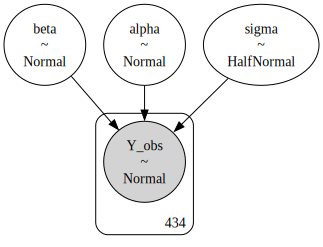

In [41]:
pm.model_to_graphviz(model)

Esaminiamo la distribuzione predittia a priori.

In [45]:
with model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [Y_obs, alpha, beta, sigma]


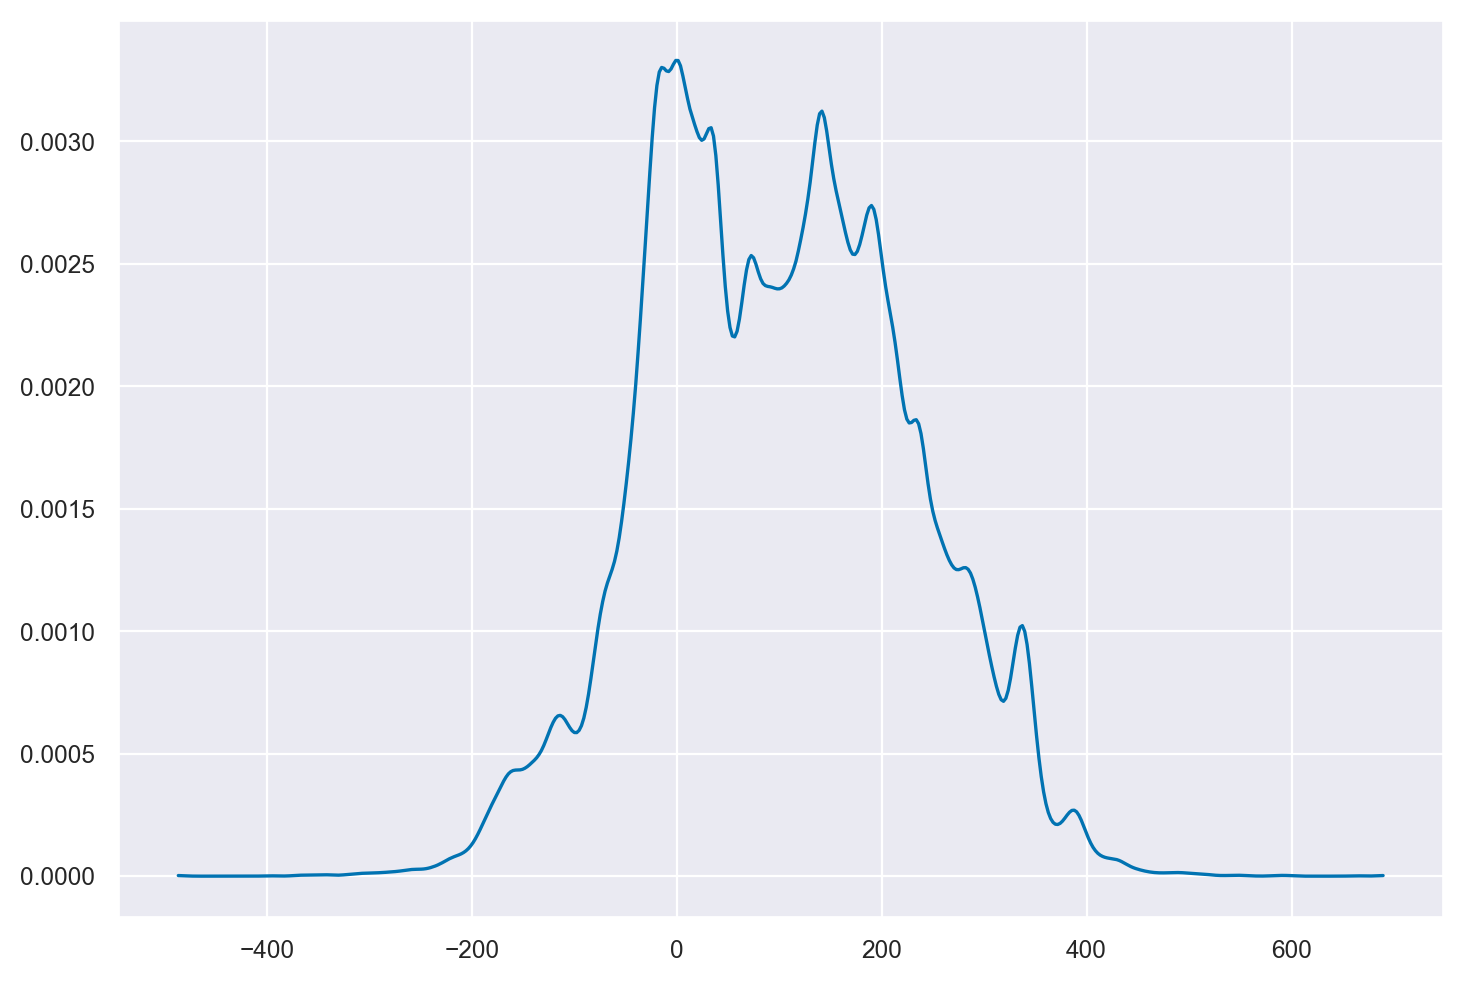

In [46]:
_ = az.plot_dist(prior_samples.prior_predictive["Y_obs"])


Eseguiamo il campionamento.

In [47]:
with model:
    trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Esaminiamo i risultati.

In [48]:
az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,77.53,2.09,73.69,81.47
beta,11.78,2.35,7.45,16.16
sigma,19.89,0.67,18.68,21.18


Si noti che $\alpha$ corrisponde alla media del primo gruppo (madri che non hanno completato le scuole superiori):

In [49]:
kidiq.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

Si noti inoltre che $\beta$ è la differenza tra le medie dei due gruppi:

In [50]:
77.548387 + 11.78

89.328387

Il nostro obiettivo è comprendere se le medie dei due gruppi sono diverse, e l'incertezza associata al parametro $\beta$ è fondamentale per rispondere a questa domanda. Se l'intervallo di credibilità associato al parametro $\beta$ non include lo 0, allora possiamo concludere con un certo grado di sicurezza che le medie dei due gruppi sono diverse. In altre parole, se l'intervallo di credibilità non contiene lo 0, allora ci sono prove convincenti che le medie dei due gruppi sono diverse.

Nel caso presente, l'intervallo di credibilità al 94% non include lo 0. Pertanto, possiamo concludere, con un livello di sicurezza soggettivo del 94%, che il QI dei bambini le cui madri hanno completato le scuole superiori tende ad essere più elevato rispetto a quello dei bambini le cui madri non hanno completato le scuole superiori.

## Dimensione dell'effetto 

Dopo aver concluso che ci sono evidenze di una differenza tra i due gruppi, ci si potrebbe chiedere quanto sia grande questa differenza. Nel caso specifico, la differenza è di 11.8 punti sulla scala del QI, il che potrebbe essere sufficiente, dal momento che la metrica del QI è comprensibile (distribuzione normale con media 100 e deviazione standard 15). Tuttavia, in generale, la differenza tra le medie di due gruppi con varianza arbitraria è difficile da comprendere se viene presentata in valore assoluto. È necessaria una misura che includa sia la differenza tra le medie che una misura dell'incertezza con cui sono state stimate le medie (della popolazione). L'indice statistico che soddisfa questo obiettivo è noto come "dimensione dell'effetto".

La dimensione dell'effetto (*effect size*) è una misura della forza dell'associazione osservata, cioè della grandezza della differenza tra i gruppi attesi, che tiene conto dell'incertezza sui dati. L'indice più comunemente utilizzato per quantificare la dimensione dell'effetto è l'indice $d$ di Cohen. Nel caso di due medie, questo indice è dato da:

$$
d={\frac {{\bar {x}}_{1}-{\bar {x}}_{2}}{s}},
$$

laddove

$$
s={\sqrt {\frac {(n_{1}-1)s_{1}^{2}+(n_{2}-1)s_{2}^{2}}{n_{1}+n_{2}-2}}}
$$

e la varianza di ciascun gruppo è calcolata come

$$
s_{1}^{2}={\frac {1}{n_{1}-1}}\sum _{i=1}^{n_{1}}(x_{1,i}-{\bar {x}}_{1})^{2}.
$$

Solitamente, l'indice $d$ di Cohen si interpreta usando la metrica seguente:

| Dimensione dell'effetto |   $d$   |
| ----------------------- | ------- |
| Very small              | 0.01	|
| Small                   | 0.20	|
| Medim                   | 0.50	|
| Large                   | 0.80	|
| Very large              | 1.20	|
| Huge                    | 2.0     |

Per una trattazione bayesiana (in un caso più complesso del presente) della stima della dimensione dell'effetto, si veda {cite}`doing_bayesian_data_an`.

Calcoliamo la dimensione dell'effetto per il caso presente, inclusa una misura di intertezza relativa a tale misura.

In [58]:
μ_m = kidiq.kid_score.mean()
μ_s = kidiq.kid_score.std() * 5

with Model() as model:
    # Priors
    alpha = Normal("alpha", mu=μ_m, sigma=μ_s)
    beta = Normal("beta", mu=0, sigma=50)
    sigma = pm.HalfNormal("sigma", sigma=50)
    # Expected value of outcome
    mu = alpha + beta * mom_hs
    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=kid_score)
    effect_size = pm.Deterministic("effect_size", beta / sigma)
    trace_ef = pm.sample(2000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


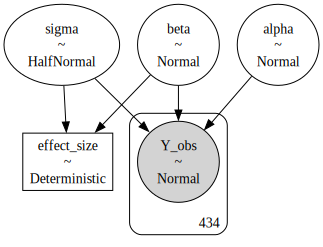

In [59]:
pm.model_to_graphviz(model)

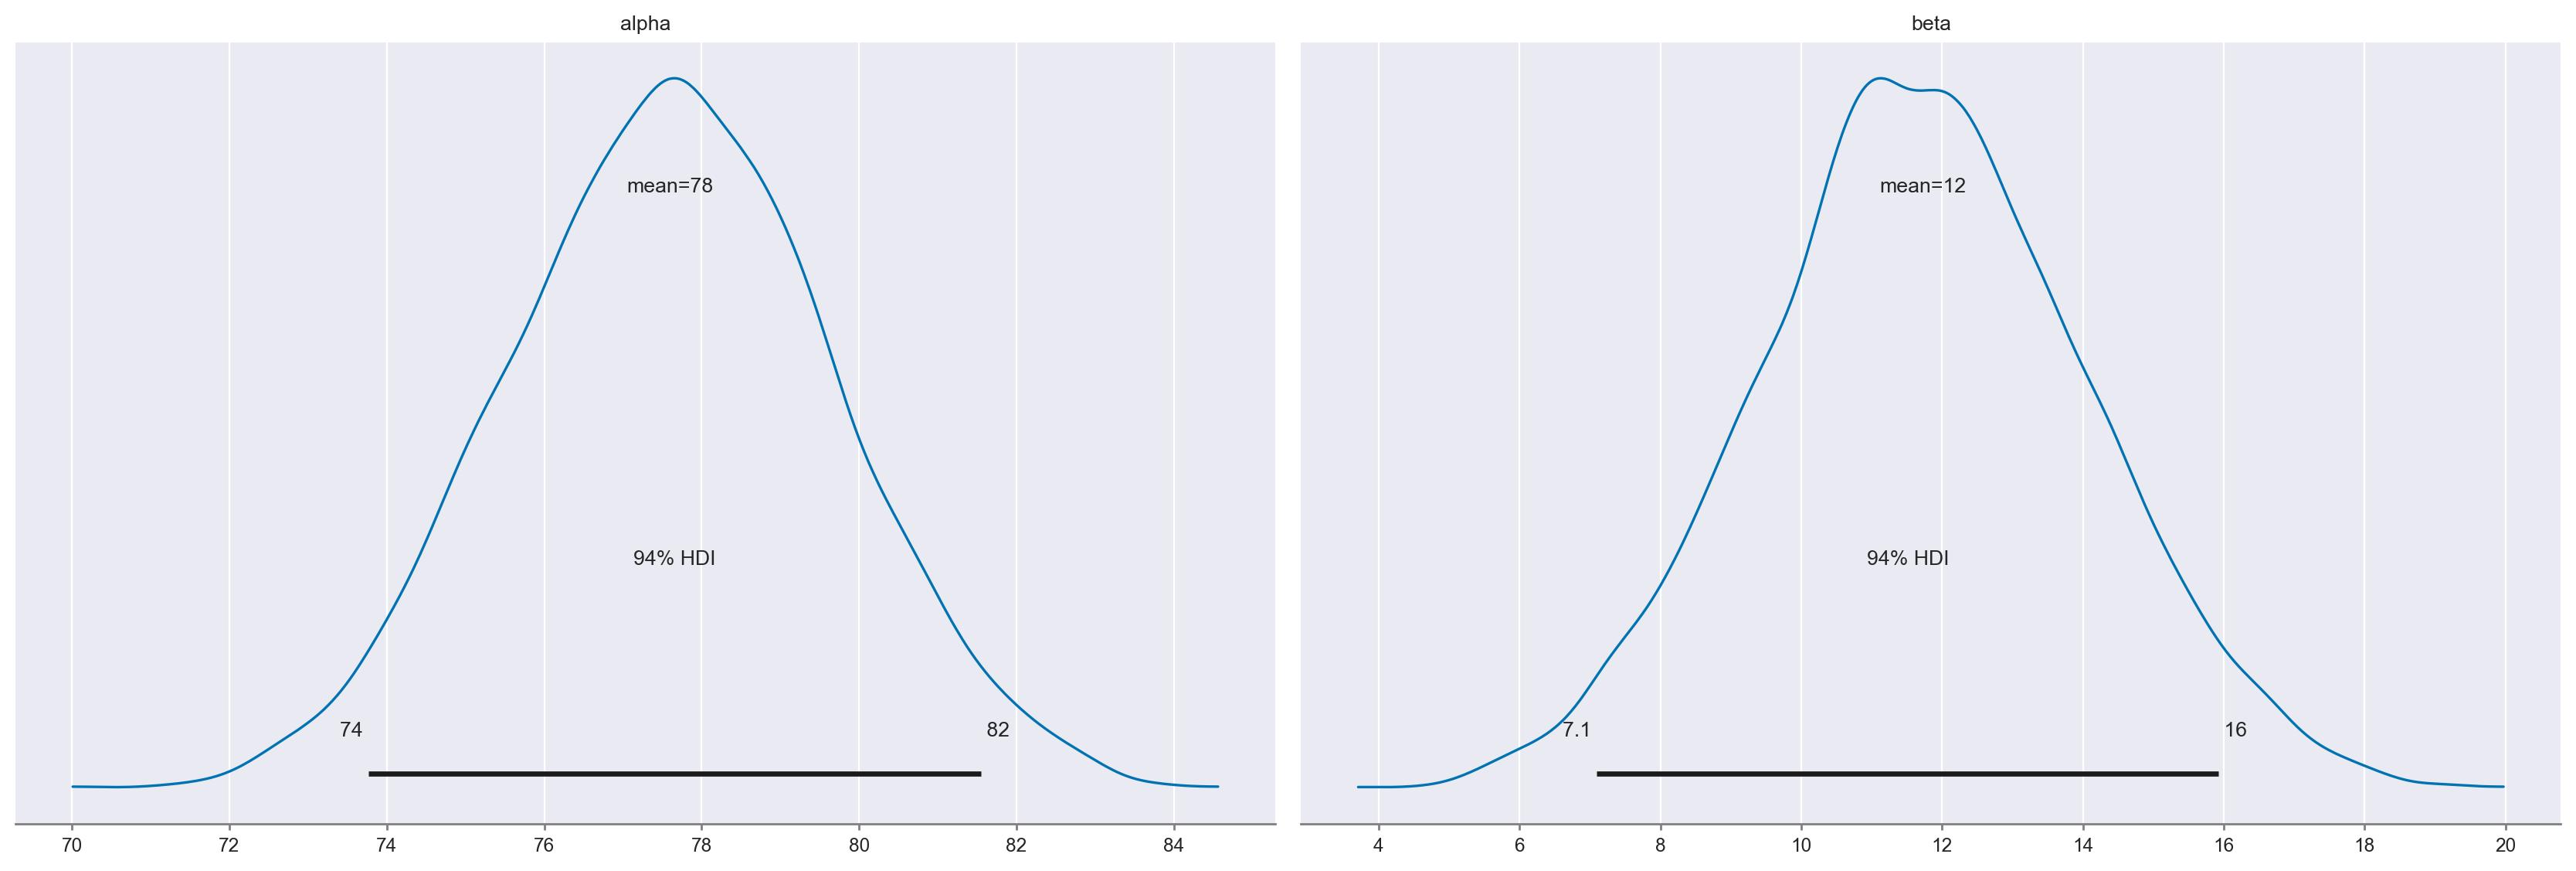

In [60]:
az.plot_posterior(trace_ef, var_names=["alpha", "beta"])
fig.tight_layout()

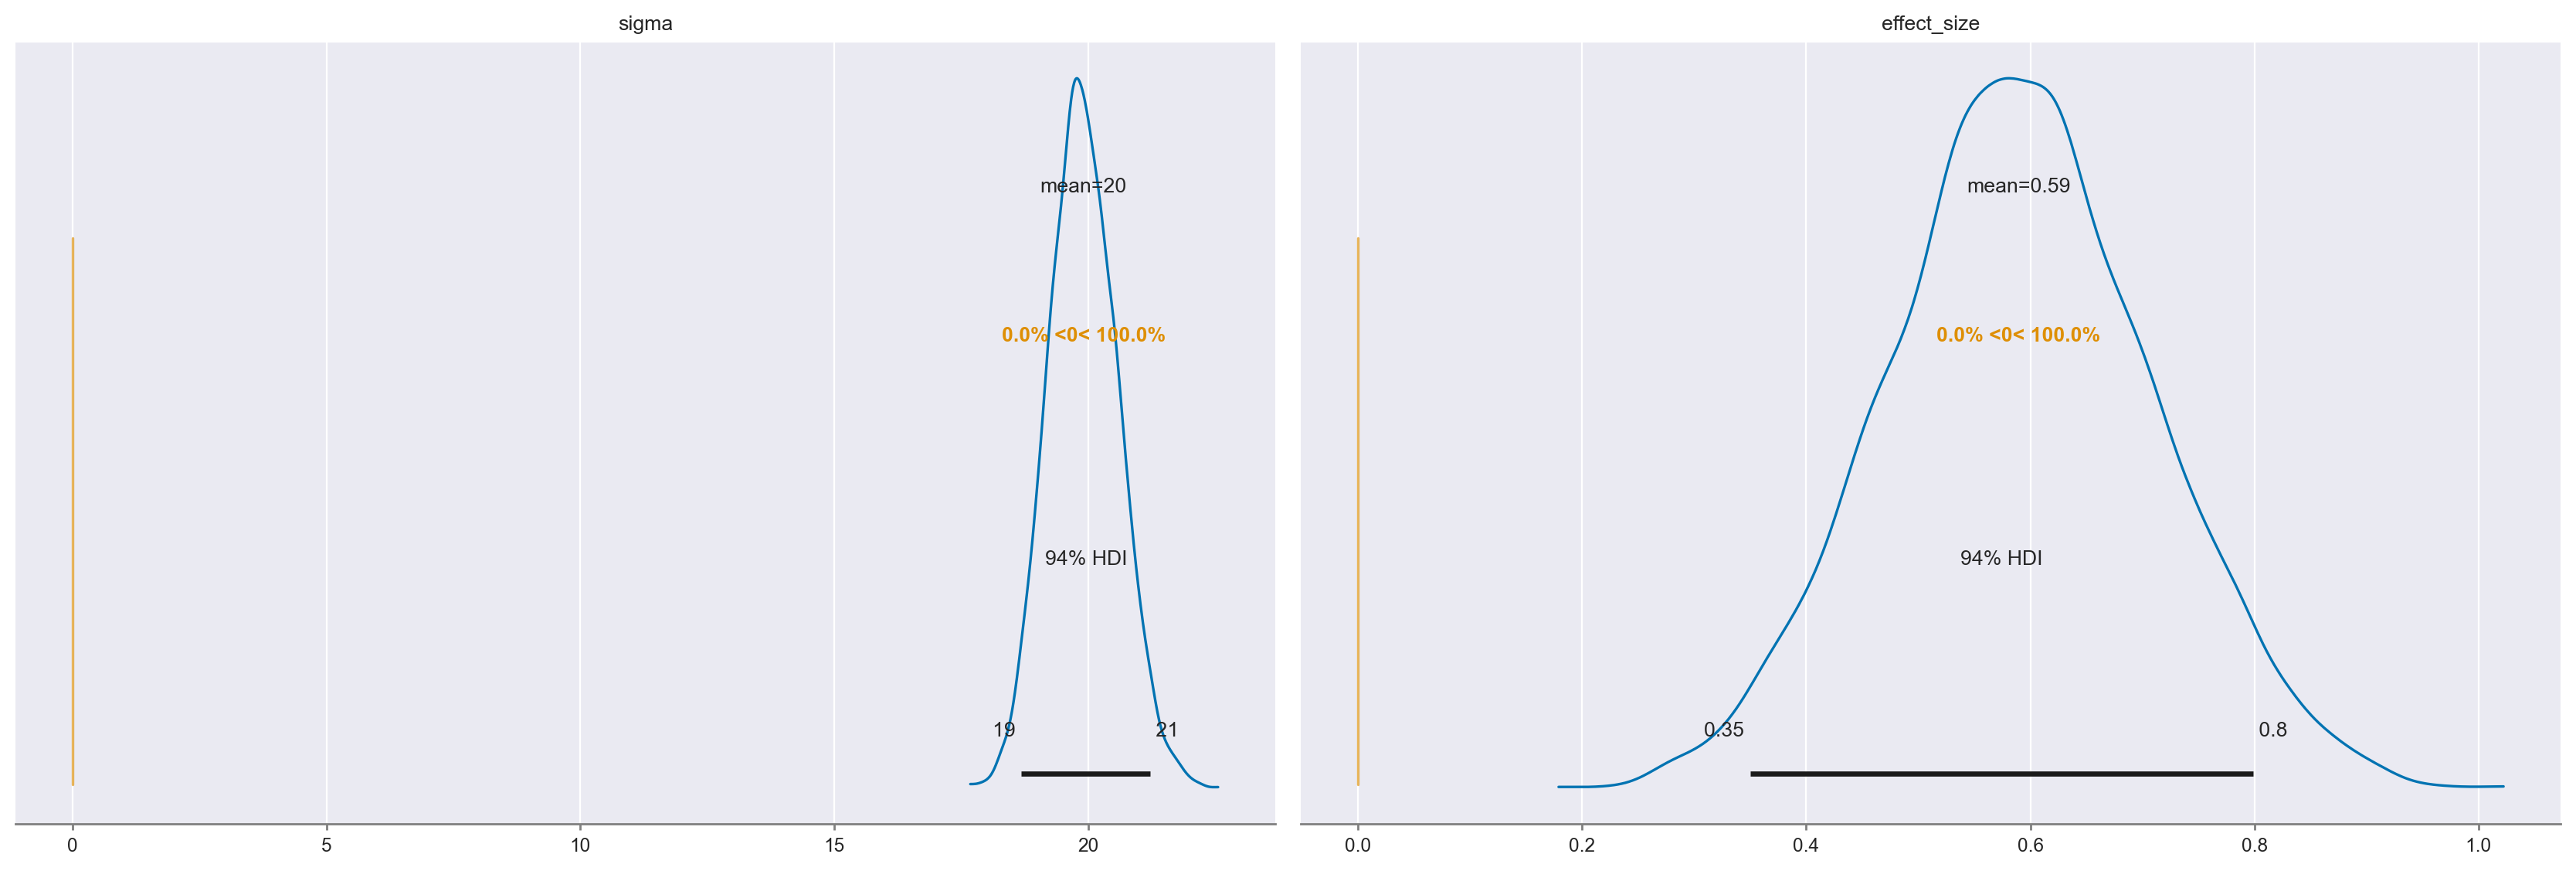

In [61]:
az.plot_posterior(trace_ef, ref_val=0, var_names=["sigma", "effect_size"])
fig.tight_layout()

In [62]:
az.summary(trace_ef, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
alpha,77.60,2.06,73.77,81.55
beta,11.72,2.33,7.10,15.93
sigma,19.91,0.68,18.69,21.23
effect_size,0.59,0.12,0.35,0.80


Possiamo dunque concludere che, per ciò che concerne l'effetto della scolarità della madre sul quoziente di intelligenza del bambino, la dimensione dell'effetto è "media".

## Watermark

In [56]:
%load_ext watermark
%watermark -n -u -v -iv 

Last updated: Sat May 06 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.2

pymc      : 5.3.0
numpy     : 1.23.5
scipy     : 1.10.1
bambi     : 0.10.0
seaborn   : 0.12.2
matplotlib: 3.7.1
arviz     : 0.15.1
pandas    : 1.5.3

